In [1]:
from commons.load_data import load_data
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch 
# https://arxiv.org/pdf/1312.6114.pdf

There are like a million ways to explain variational autoencoders that are needlessly complicated. Simply look at the loss function to see what is going on:

There is the constuction loss: how far from the input the generated image is 

Then there is the KL divergence loss which is a bit more complicated.
<ol>
    <li> mu and log_var are generated in the encoder, they are then compared to a smaple from a normal distrobution. 
    <li> Basically mu and log_var are penalized if they do not produce a normal distrobution with mean = 0 and std = 1.0
    <li> this "regularizes" the latent space to a normal distrobution

In [2]:
INPUT_DIMS = (28, 28)

class VAE(torch.nn.Module):
    def __init__(self, latent_dims = 16) -> None:
        super(VAE, self).__init__()

        # encoder
        self.encoder_conv_layers = [
            torch.nn.Conv2d(1, 32, (3, 3), stride = 2, padding = 1),
            torch.nn.Conv2d(32, 64, (3, 3), stride = 2, padding = 1)
        ]

        self.encoder_linear = torch.nn.Linear(7 * 7 * 64, 32)
        self.linear_mu = torch.nn.Linear(32, latent_dims)
        self.linear_log_var = torch.nn.Linear(32, latent_dims)

        # decoder
        self.decoder_linear = torch.nn.Linear(latent_dims, 7 * 7 * 64)

        self.decoder_transconv_layers = [
            torch.nn.ConvTranspose2d(64, 32, 3, stride = 2, output_padding = 1, padding = 1),
            torch.nn.ConvTranspose2d(32, 32, 3, stride = 2, output_padding = 1, padding = 1), 
            torch.nn.ConvTranspose2d(32, 1, 3, stride = 1, padding = 1), 
        ]

    def encoder(self, input):
        x = self.encoder_conv_layers[0](input)
        x = F.leaky_relu(x)

        for layer in self.encoder_conv_layers[1:]:
            x = layer(x)
            x = F.leaky_relu(x)

        x = torch.flatten(x, start_dim = 1)

        x = self.encoder_linear(x)
        x = F.leaky_relu(x)

        mu = self.linear_mu(x)
        log_var = self.linear_log_var(x)

        epsilon = torch.randn_like(mu)

        sample = mu + torch.exp(log_var / 2) * epsilon
        return sample, mu, log_var

    def decoder(self, latent_space):
        x = self.decoder_linear1(latent_space)
        x = F.leaky_relu(x)
        
        x = self.decoder_linear2(x)
        x = F.leaky_relu(x)

        x = torch.reshape(x, (-1, 64, 7, 7))

        for layer in self.decoder_transconv_layers[:-1]:
            x = layer(x)
            x = F.leaky_relu(x)

        x = self.decoder_transconv_layers[-1](x)
        output = torch.sigmoid(x)
        
        return output

    def forward(self, input):
        latent_space, mu, log_var = self.encoder(input)
        output = self.decoder(latent_space)
        return output, mu, log_var

In [3]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

train_data, test_data = load_data() # load in data

epochs = 30
batch_size = 64

dkl_weight = 1

train = torch.utils.data.DataLoader(train_data, batch_size = batch_size)
test = torch.utils.data.DataLoader(test_data, batch_size = batch_size)

In [4]:
def loss_fn(output, input, mu, log_var):
    con_loss = F.binary_cross_entropy(output, input)
    dkl_loss = -0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), axis = 1)
    dkl_loss = torch.mean(dkl_loss)
    return dkl_loss * dkl_weight + con_loss

model = VAE(latent_dims = 10)
opt = torch.optim.Adam(model.parameters(), lr = 1e-4, weight_decay = 1e-5) 
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, 'min', factor = .2, patience = 3, verbose = True, cooldown = 3)

model.to(device)

VAE(
  (encoder_linear): Linear(in_features=3136, out_features=32, bias=True)
  (linear_mu): Linear(in_features=32, out_features=10, bias=True)
  (linear_log_var): Linear(in_features=32, out_features=10, bias=True)
  (decoder_linear1): Linear(in_features=10, out_features=32, bias=True)
  (decoder_linear2): Linear(in_features=32, out_features=3136, bias=True)
)

In [5]:
print(f'Training Started 0/{epochs} epochs')
for epoch in range(epochs):
    train_loss = 0 # init train loss to 0

    for imgs, _ in tqdm(train, mininterval= 0.5):
        opt.zero_grad()

        imgs = imgs.to(device)
        
        outputs, mu, log_var = model(imgs)
        loss = loss_fn(outputs, imgs, mu, log_var)
        
        loss.backward()
        opt.step()
        train_loss += loss.item() 

    test_loss = 0 
    with torch.no_grad():
        for imgs, _ in test:
            imgs = imgs.to(device)
            outputs, mu, log_var = model(imgs)
            loss = loss_fn(outputs, imgs, mu, log_var)
            test_loss += loss.item() 
            
    train_loss /= len(train)
    test_loss /= len(test)

    print(f"Epoch: {epoch + 1}/{epochs} complete\tTrain loss: {train_loss:.5f}\t Test loss: {test_loss:.5f}")

    scheduler.step(test_loss)

Training Started 0/30 epochs


100%|██████████| 938/938 [00:45<00:00, 20.55it/s]


Epoch: 1/30 complete	Train loss: 0.67426	 Test loss: 0.62063


 81%|████████  | 758/938 [00:39<00:08, 20.15it/s]

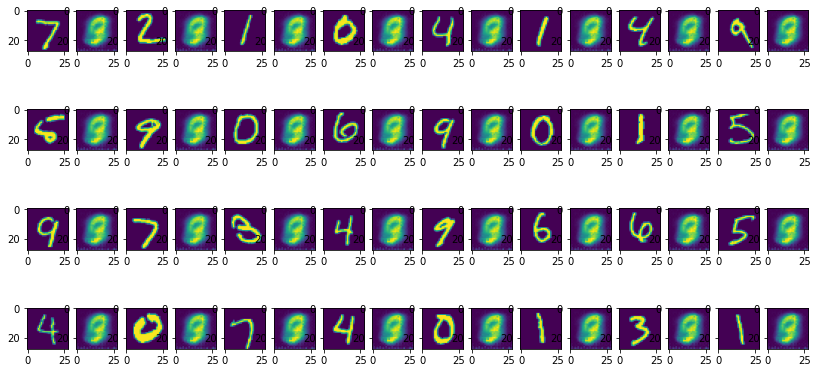

In [ ]:
images, _ = iter(test).next()
_, ax = plt.subplots(4, 16, figsize = (14, 7))
with torch.no_grad():
    outputs, _, _ = model(images)

ax_flat = ax.flatten()
for i in range(0, len(ax_flat), 2):
    ax_flat[i+1].imshow(outputs[i//2][0].numpy())
    ax_flat[i].imshow(images[i//2][0].numpy())